In [616]:
import pandas as pd
import numpy as np
import math
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import PatternFill, Alignment
import statistics
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

Settings

In [617]:
FILE_NAME = "data.xlsx"
TIME_INCREMENT = 5.08
SIZE_OF_INCLUSION = 1.351
IMAGE_NAME = "3K_02"

Sub Functions

In [618]:
def truncate(x, decimals):
    if isinstance(x, float):
        factor = 10 ** decimals
        return math.trunc(x * factor) / factor
    return x

def avg(ws, col, start_row, end_row):
    values = [ws[f"{col}{row}"].value for row in range(start_row, end_row + 1)]
    values = [v for v in values if isinstance(v, (int, float))]
    return statistics.mean(values) if values else None

Clean Data

In [619]:
df = pd.read_excel(FILE_NAME)

analysis = df.iloc[:, :3].copy()

analysis.iloc[:, 0] = analysis.iloc[:, 0].apply(lambda x: truncate(x, 3))
analysis.iloc[:, 1] = analysis.iloc[:, 1].apply(lambda x: truncate(x, 2))
analysis.iloc[:, 2] = analysis.iloc[:, 2].apply(lambda x: truncate(x, 2))

print(analysis)

    Intensity Mean Value 1  Intensity Mean Value 2  Intensity Mean Value 3
0                   51.346                   11.84                    0.00
1                   51.427                   11.87                    0.00
2                   51.729                   12.05                    0.00
3                   56.204                   12.00                    0.00
4                   57.743                   11.68                    0.00
5                   34.074                   11.56                    0.00
6                   44.237                   11.30                    0.00
7                   46.663                   11.31                    0.00
8                   48.675                   11.35                    0.00
9                   47.560                   11.33                    0.00
10                  47.875                   11.11                    0.00
11                  52.115                   11.08                    0.01
12                  53.86

In [620]:
# Step 3 (safe version): Add or replace cycle column
analysis['cycle'] = list(range(1, len(analysis) + 1))

# Reorder so 'cycle' is the first column
analysis = analysis[['cycle'] + [col for col in analysis.columns if col != 'cycle']]

cols = analysis.columns.tolist()

cols[1] = 'ROI1'
cols[2] = 'ROI2'
cols[3] = 'ROI3'

analysis.columns = cols

num_rows = len(analysis)
time_column = [round((i + 1) * TIME_INCREMENT, 2) for i in range(num_rows)]

analysis["TIME (sec)"] = time_column

analysis.insert(5, 'ROI1 ', [None] * num_rows)
analysis.insert(6, 'ROI2 ', [None] * num_rows)
analysis.insert(7, 'ROI3 ', [None] * num_rows)

analysis.to_excel("analysis.xlsx", index=False)



In [621]:
# Load the existing workbook and worksheet
wb = load_workbook("analysis.xlsx")
ws = wb.active  # or wb['SheetName'] if named

red_accent_fill = PatternFill(start_color="F4CCCC", end_color="F4CCCC", fill_type="solid")
orange_accent_fill = PatternFill(start_color="FCE5CD", end_color="FCE5CD", fill_type="solid")
aqua_accent_fill = PatternFill(start_color="B7DEE8", end_color="B7DEE8", fill_type="solid")
dark_blue_accent_fill = PatternFill(start_color="00B0F0", end_color="00B0F0", fill_type="solid")
purple_accent_fill = PatternFill(start_color="CCC0DA", end_color="CCC0DA", fill_type="solid")
light_pink_accent_fill = PatternFill(start_color="DA9694", end_color="DA9694", fill_type="solid")
light_brown_accent_fill = PatternFill(start_color="C4BD97", end_color="C4BD97", fill_type="solid")
light_green_accent_fill = PatternFill(start_color="EBF1DE", end_color="EBF1DE", fill_type="solid")
blue_accent_fill = PatternFill(start_color="538DD5", end_color="538DD5", fill_type="solid")


# Manual calculations
f6 = avg(ws, "B", 2, 6)
g6 = avg(ws, "C", 2, 6)
h6 = avg(ws, "D", 2, 6)
g7 = avg(ws, "C", 7, 41)
j7 = g7 / g6 if g6 else None

# Assign static labels
ws["I6"] = "AVERAGE 5 images before bleaching"
ws["I7"] = "AVERAGE all images after bleaching"
ws["J6"] = "r RO2"
ws["K1"] = "normalized F ROI1"
ws["L6"] = "plateau best fit value (prism)"
ws["M6"] = "mobile fraction Fm"
ws["N6"] = "immobile fraction Fi"
ws["O6"] = "size of inclusion"
ws["P6"] = "average normalized F ROI1 before bleaching"

# Assign computed values
ws["F6"] = f6
ws["G6"] = g6
ws["H6"] = h6
ws["G7"] = g7
ws["J7"] = j7
ws["O7"] = SIZE_OF_INCLUSION

# Compute normalized F ROI1 manually in K2:K{end}
for row in range(2, ws.max_row + 1):
    b = ws[f"B{row}"].value
    d = ws[f"D{row}"].value
    if isinstance(b, (int, float)) and isinstance(d, (int, float)) and j7:
        ws[f"K{row}"] = (b - d) / j7
    else:
        ws[f"K{row}"] = None

p7 = avg(ws, "K", 2, 6)
ws["P7"] = p7


for cell in ["F6", "G6", "H6", "I6"]:
    ws[cell].fill = red_accent_fill

for cell in ["G7", "H7", "I7"]:
    ws[cell].fill = orange_accent_fill  

for cell in ["J6", "J7"]:
    ws[cell].fill = aqua_accent_fill

for cell in ["L6", "L7"]:
    ws[cell].fill = purple_accent_fill

for cell in ["M6", "M7"]:
    ws[cell].fill = light_pink_accent_fill

for cell in ["N6", "N7"]:
    ws[cell].fill = light_brown_accent_fill

for cell in ["O6", "O7"]:
    ws[cell].fill = light_green_accent_fill

for cell in ["P6", "P7"]:
    ws[cell].fill = blue_accent_fill

for row in range(1, ws.max_row + 1):
    ws[f"K{row}"].fill = dark_blue_accent_fill
    
ws.row_dimensions[6].height = 57
ws.column_dimensions["I"].width = 16
ws.column_dimensions["L"].width = 12.57
ws.column_dimensions["P"].width = 11.14


ws["I6"].alignment = Alignment(wrap_text=True)
ws["I7"].alignment = Alignment(wrap_text=True)
ws["L6"].alignment = Alignment(wrap_text=True)
ws["M6"].alignment = Alignment(wrap_text=True)
ws["N6"].alignment = Alignment(wrap_text=True)
ws["O6"].alignment = Alignment(wrap_text=True)
ws["P6"].alignment = Alignment(wrap_text=True)

column_indices = [1, 2, 3, 4, 5, 11]

for col_idx in column_indices:
    col_letter = get_column_letter(col_idx)
    max_length = 0
    for cell in ws[col_letter]:
        if cell.value:
            max_length = max(max_length, len(str(cell.value)))
    
    ws.column_dimensions[col_letter].width = max_length + 2  # Add some padding

wb.save("analysis.xlsx")

Fit Exponential Model

In [622]:
# Read the Excel file (assumes values already calculated in Excel)
df = pd.read_excel("analysis.xlsx")

# Get values from E7 down (Excel row 7 → index 6)
x = df.iloc[5:, 4].values   # Column E is index 4
y = df.iloc[5:, 10].values  # Column K is index 10

def exp_plateau_fixed_y0(x, YM, k):
    return YM * (1 - np.exp(-k * x))

# Fit the model
popt, _ = curve_fit(exp_plateau_fixed_y0, x, y, p0=[max(y), 0.01], bounds=([0, 1e-8], [np.inf, np.inf]))
YM, k = popt

# Generate fit line
x_fit = np.linspace(min(x), max(x), 200)
y_fit = exp_plateau_fixed_y0(x_fit, *popt)

plateu = YM
plateu = round(plateu, 2)
print(f"Plateau value (YM): {plateu}")

Plateau value (YM): 63.45


In [623]:
wb = load_workbook("analysis.xlsx")
ws = wb.active 

# Write the plateau value to the worksheet
ws["L7"] = plateu
m7 = plateu / p7 
n7 = 1 - m7 
ws["M7"] = m7
ws["N7"] = n7

wb.save("analysis.xlsx")

column_e = df.iloc[:, 4].dropna()

time_frame = column_e.iloc[-1]

Fit Curve Excel

In [624]:
x_generated = np.linspace(0, time_frame, 1000)
y_generated = exp_plateau_fixed_y0(x_generated, YM, k)

# Create DataFrame and write to Excel
fit_df = pd.DataFrame({
    "Time (sec)": x_generated,
    "Fluorescence intensity": y_generated, 
    "Fluorescence intensity (percentage)": (y_generated * 100) / p7
})


fit_df.to_excel("Fit curve.xlsx", index=False)

Generate Graphs

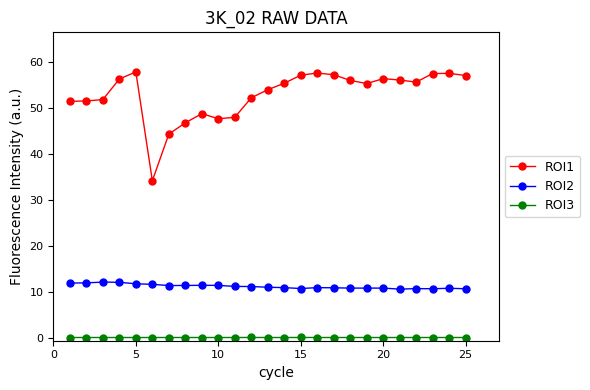

In [625]:
df = pd.read_excel("analysis.xlsx")


# Get all rows from the first 4 columns
df = df.iloc[:, :4]
df.columns = ["cycle", "ROI1", "ROI2", "ROI3"]

# Create plot
plt.figure(figsize=(6, 4))

# Plot each ROI with matching color, marker, and size
plt.plot(df["cycle"], df["ROI1"], marker='o', markersize=5, color='red', label='ROI1', linewidth=1)
plt.plot(df["cycle"], df["ROI2"], marker='o', markersize=5, color='blue', label='ROI2', linewidth=1)
plt.plot(df["cycle"], df["ROI3"], marker='o', markersize=5, color='green', label='ROI3', linewidth=1)

# Axis labels and title
plt.xlabel("cycle", fontsize=10)
plt.ylabel("Fluorescence Intensity (a.u.)", fontsize=10)
plt.title(f"{IMAGE_NAME} RAW DATA", fontsize=12)

# Axes limits and ticks
plt.xlim(0, df["cycle"].max() + 2)
plt.ylim(-0.7, df[["ROI1", "ROI2", "ROI3"]].max().max() * 1.15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Legend styling
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9, frameon=True)

# Remove grid, apply tight layout
plt.grid(False)
plt.tight_layout()
plt.show()

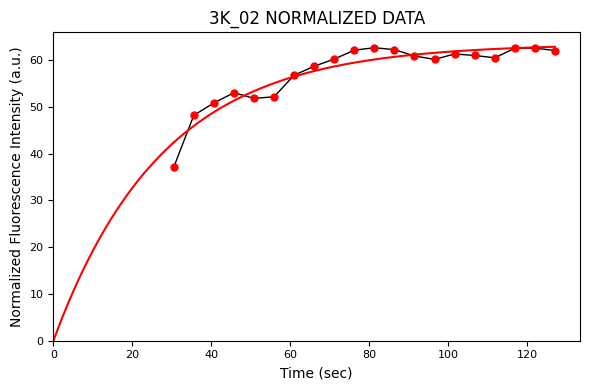

In [626]:
plt.figure(figsize=(6, 4))
plt.plot(x, y, '-', color='black', linewidth=1)

# Plot red dots on top
plt.plot(x, y, 'o', color='red', markersize=5)
plt.plot(x_generated, y_generated, '-', color='red', label='Fit curve')


# Axis labels and title
plt.xlabel("Time (sec)", fontsize=10)
plt.ylabel("Normalized Fluorescence Intensity (a.u.)", fontsize=10)
plt.title(f"{IMAGE_NAME} NORMALIZED DATA", fontsize=12)

# Format ticks and legend
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Clean layout
plt.grid(False)
plt.tight_layout()
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

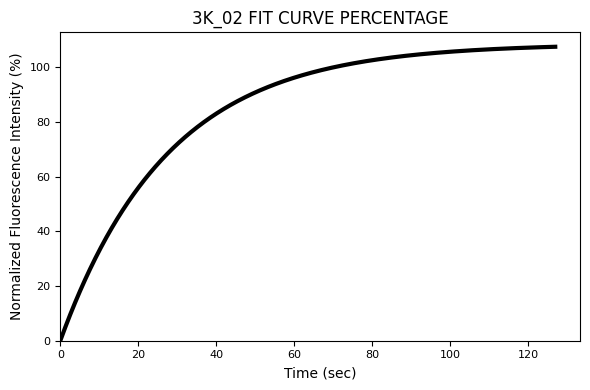

In [627]:
plt.figure(figsize=(6, 4))

plt.plot(x_generated, fit_df["Fluorescence intensity (percentage)"], '-', color='black', label='Fit curve', linewidth=3)


# Axis labels and title
plt.xlabel("Time (sec)", fontsize=10)
plt.ylabel("Normalized Fluorescence Intensity (%)", fontsize=10)
plt.title(f"{IMAGE_NAME} FIT CURVE PERCENTAGE", fontsize=12)

# Format ticks and legend
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Clean layout
plt.grid(False)
plt.tight_layout()
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()